<a href="https://colab.research.google.com/github/jnunez03/CppFolder/blob/master/CookingRegiWallAlerts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regi Wall Alert**

In [3]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

qnew = """
SELECT
day, 
dayName,
dc,
ds,
sum(users) as users,  
SUM(case when if_hit_regiwall = 1 THEN users ELSE 0 END) as hitRegiWall,
((SUM(case when if_hit_regiwall = 1 THEN users ELSE 0 END) / sum(users) *1.0) *100) as percentHitRegiWall
FROM (
        SELECT 
              day,
              format_datetime('%A',cast(day as datetime)) as dayName, 
              if_hit_regiwall, 
              dc,
              ds,
              count(distinct user_id) as users
        FROM (
                SELECT
                      day, 
                      user_id,  -- agent_id json_kidd.user.tracking.first_referrer
                      dc,
                      ds,
                      if_hit_regiwall, 
                      date_hit_regiwall
                FROM (
                      SELECT
                          DATE(p.timestamps.last_updated_dt_nyct) as day,
                          cast(agent_id as string) as user_id,   -- agent_id
                          r.derived_channel as dc,
                          r.derived_source as ds,
                          MAX(CASE WHEN i.module.name LIKE '%regiwall%' then 1 ELSE 0 END) as if_hit_regiwall,
                          MAX(CASE WHEN i.module.name LIKE '%regiwall%' then i.dt_nyct ELSE NULL END) as date_hit_regiwall
                       FROM `nyt-eventtracker-prd.et.page` p   -- ET2 starts May 06
                       LEFT JOIN `nyt-eventtracker-prd.et_derived.referrer` r on p. pageview_id = r.pageview_id
                       LEFT JOIN p.impressions i
                       WHERE DATE(p._pt) >= '2019-10-01'
                       AND LOWER(p.source_app) = 'nytcooking'
                       and r.derived_channel != 'email'
                       AND (p.agent.browser.is_spider is null or agent.browser.is_spider = false)
                       and p.json_kidd.user.regi_id is null 
                       GROUP BY 1,2,3,4
                     )
             )  
        GROUP BY 1,2,3,4,5
        ORDER BY 1 desc
       )
group by 1,2,3,4
order by 1 desc 
"""
# ---------------------------------------------------------------------------------------
# without email users
q = """
SELECT
day, 
dayName,
sum(users) as users,  
SUM(case when if_hit_regiwall = 1 THEN users ELSE 0 END) as hitregiwall,
((SUM(case when if_hit_regiwall = 1 THEN users ELSE 0 END) / sum(users) *1.0) *100) as percenthitregiwall
FROM (
        SELECT 
              day,
              format_datetime('%A',cast(day as datetime)) as dayName, 
              if_hit_regiwall, 
              count(distinct user_id) as users
        FROM (
                SELECT
                      day, 
                      user_id,  -- agent_id json_kidd.user.tracking.first_referrer
                      if_hit_regiwall, 
                      date_hit_regiwall
                FROM (
                      SELECT
                          DATE(p.timestamps.last_updated_dt_nyct) as day,
                          cast(agent_id as string) as user_id,   -- agent_id
                          MAX(CASE WHEN i.module.name LIKE '%regiwall%' then 1 ELSE 0 END) as if_hit_regiwall,
                          MAX(CASE WHEN i.module.name LIKE '%regiwall%' then i.dt_nyct ELSE NULL END) as date_hit_regiwall
                       FROM `nyt-eventtracker-prd.et.page` p   -- ET2 starts May 06
                       LEFT JOIN `nyt-eventtracker-prd.et_derived.referrer` r on p. pageview_id = r.pageview_id
                       LEFT JOIN p.impressions i
                       WHERE DATE(p._pt) >= '2019-07-01'
                       AND LOWER(p.source_app) = 'nytcooking'
                       AND r.derived_channel != 'email'
                       AND (p.agent.browser.is_spider is null or agent.browser.is_spider = false)
                       and p.json_kidd.user.regi_id is null 
                       GROUP BY 1,2
                     )
             )  
        GROUP BY 1,2,3
        ORDER BY 1 desc
       )
group by 1,2
order by 1 desc  
"""

q1 = """ SELECT *
FROM `nyt-bigquery-beta-workspace.Cooking.CKAgents_RegiWallHits` 
order by day desc
"""

# importing the data
df = pd.read_gbq(q1,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')


# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=3),'\n',df.tail(n=3))

               users    hitregiwall  percenthitregiwall
count     140.000000     140.000000          140.000000
mean   220570.957143   69553.150000           31.112600
std     46203.771918   20473.556218            3.209697
min    159935.000000   43821.000000           23.659797
25%    184259.500000   54896.500000           28.957184
50%    209603.500000   63366.000000           30.492364
75%    247128.000000   80209.750000           32.604165
max    396802.000000  141531.000000           42.104722  
 
 *Data Types Below* 
 
 day                   datetime64[ns]
dayName                       object
users                          int64
hitregiwall                    int64
percenthitregiwall           float64
dtype: object  
 
          day   dayName   users  hitregiwall  percenthitregiwall
0 2019-11-17    Sunday  396802       141531           35.667915
1 2019-11-16  Saturday  352139       132289           37.567267
2 2019-11-15    Friday  249329        87276           35.004352 
       

In [21]:
df.head(n=20)

#dfnew.dc.value_counts

,day,dayName,users,hitregiwall,percenthitregiwall
1,2019-11-13,Wednesday,261996,89297,34.083345
2,2019-11-12,Tuesday,277722,94499,34.026473
3,2019-11-11,Monday,323458,104174,32.206345
4,2019-11-10,Sunday,356446,119199,33.440970
5,2019-11-09,Saturday,315425,116960,37.080130
6,2019-11-08,Friday,238043,81811,34.368160
7,2019-11-07,Thursday,241857,87391,36.133335
8,2019-11-06,Wednesday,262560,110551,42.105043
9,2019-11-05,Tuesday,220757,70427,31.902499
10,2019-11-04,Monday,253817,81946,32.285466


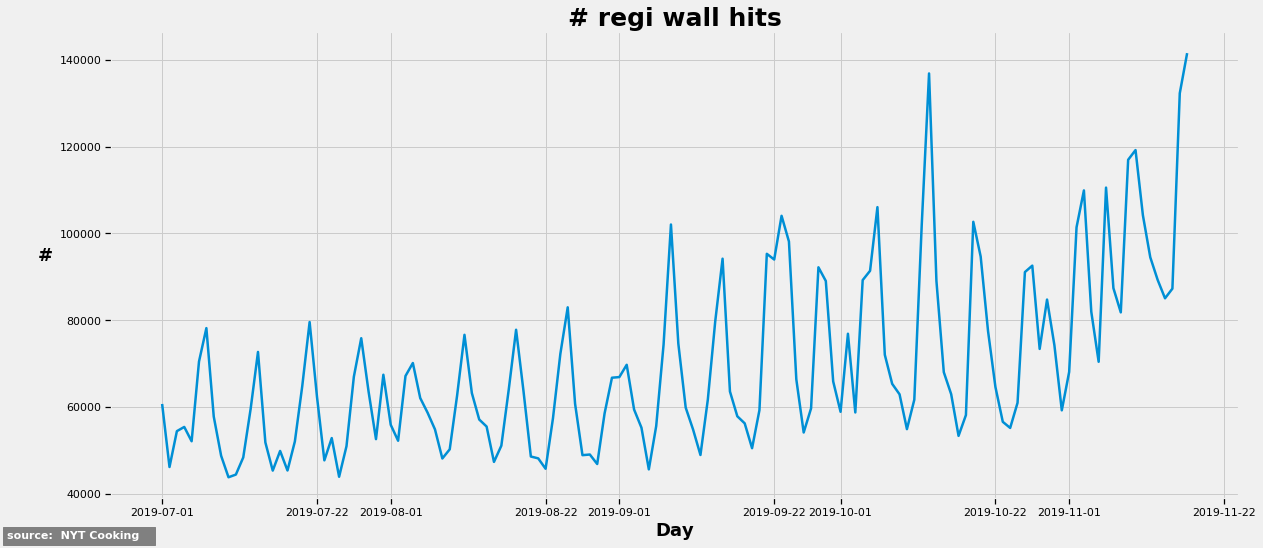

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=df)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('# regi wall hits',fontsize=25,weight='bold')
plt.ylabel('#   ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

# Data Starting from September 1st
## For Thresholds

In [0]:
dfnew = df[df['day'] >= '2019-09-01']

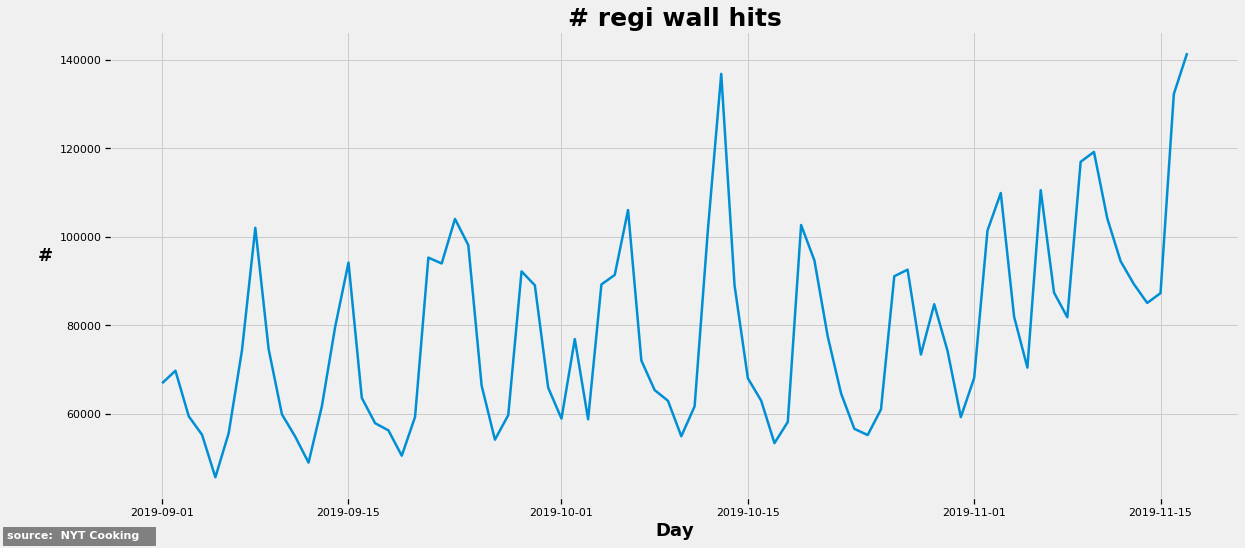

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfnew)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('# regi wall hits',fontsize=25,weight='bold')
plt.ylabel('#   ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [0]:
dfMon = dfnew[(dfnew['dayName'] == 'Monday') & (dfnew['day'] <= '2019-11-01')]

dfTue = dfnew[(dfnew['dayName'] == 'Tuesday') & (dfnew['day'] <= '2019-11-01') ]

dfWed = dfnew[(dfnew['dayName'] == 'Wednesday') & (dfnew['day'] <= '2019-11-01') ]

dfThurs = dfnew[(dfnew['dayName'] == 'Thursday') & (dfnew['day'] <= '2019-11-01') ]

dfFri =  dfnew[(dfnew['dayName'] == 'Friday') & (dfnew['day'] <= '2019-11-01') ]

dfSat = dfnew[(dfnew['dayName'] == 'Saturday') & (dfnew['day'] <= '2019-11-01') ]

dfSun = dfnew[(dfnew['dayName'] == 'Sunday') & (dfnew['day'] <= '2019-11-01') ] 

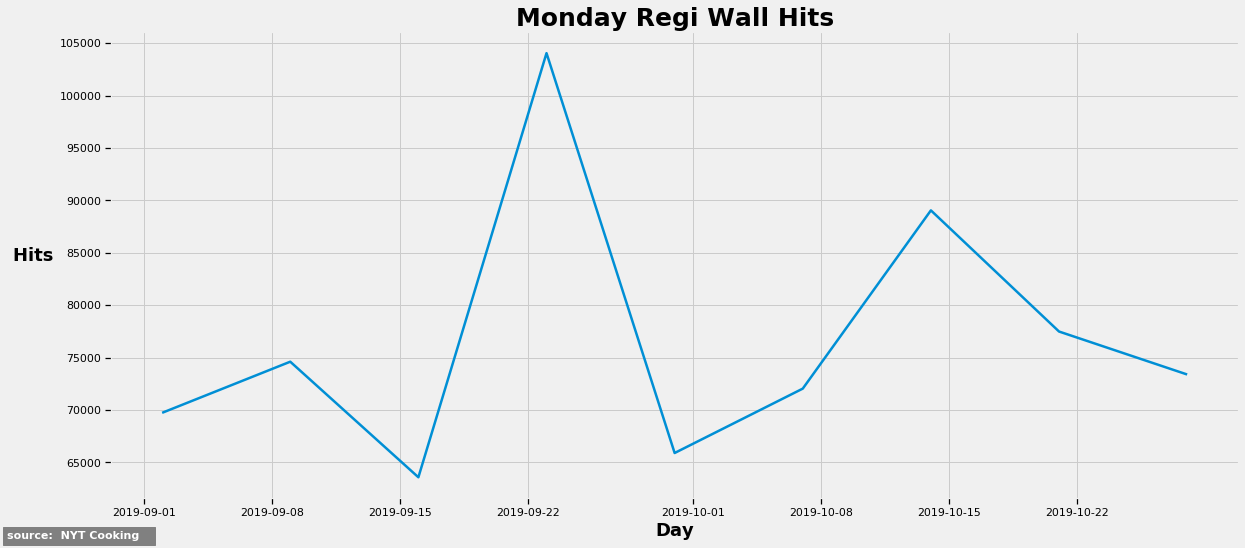

In [20]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfMon)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Monday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

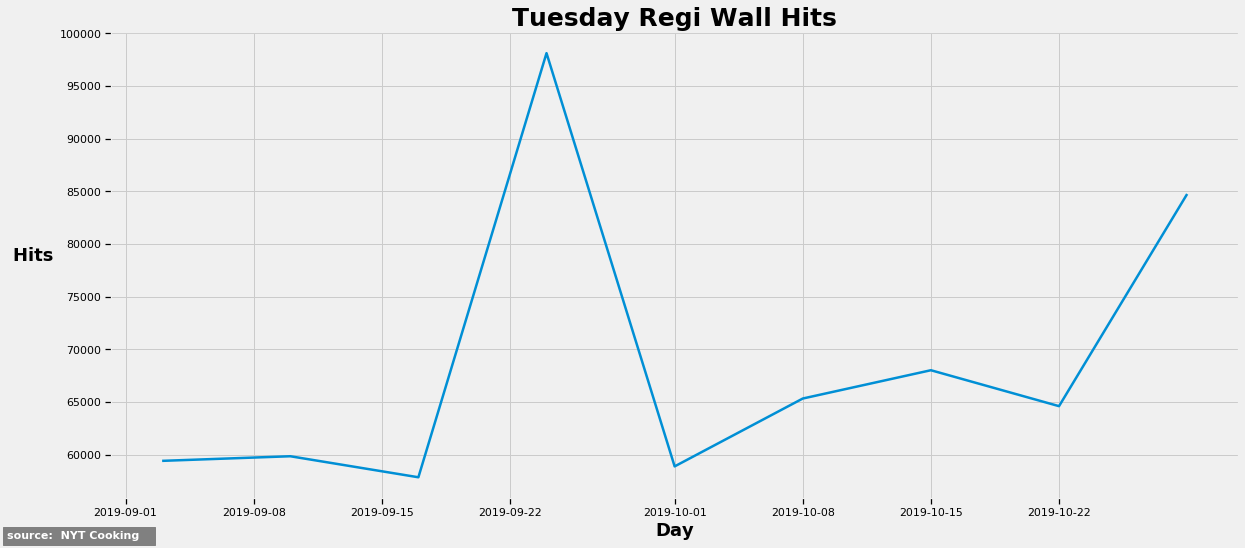

In [21]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfTue)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Tuesday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

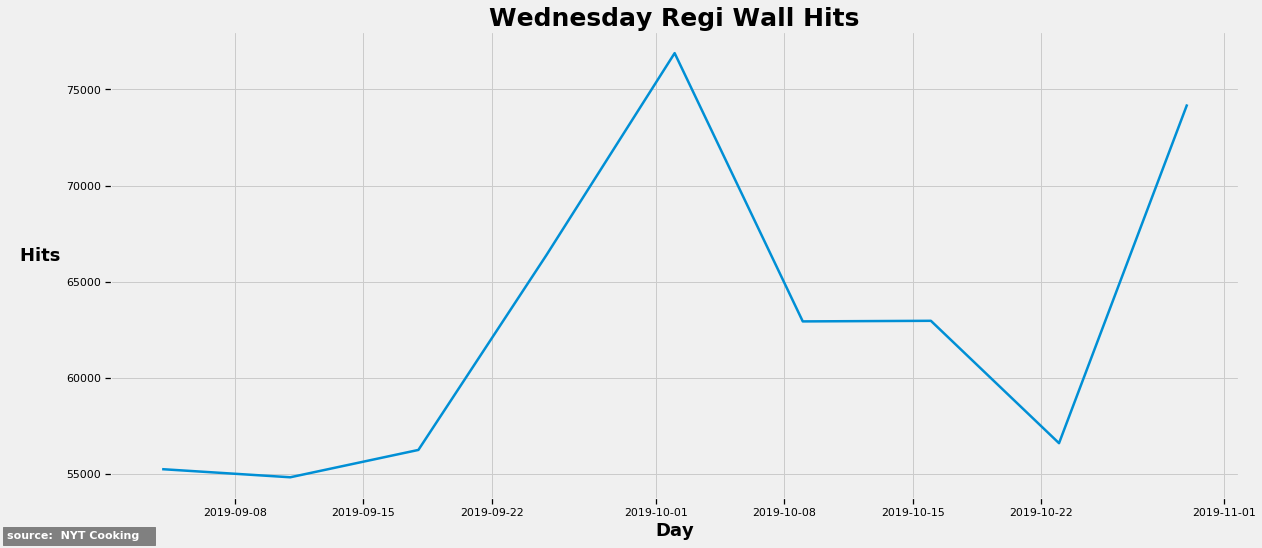

In [22]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfWed)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Wednesday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

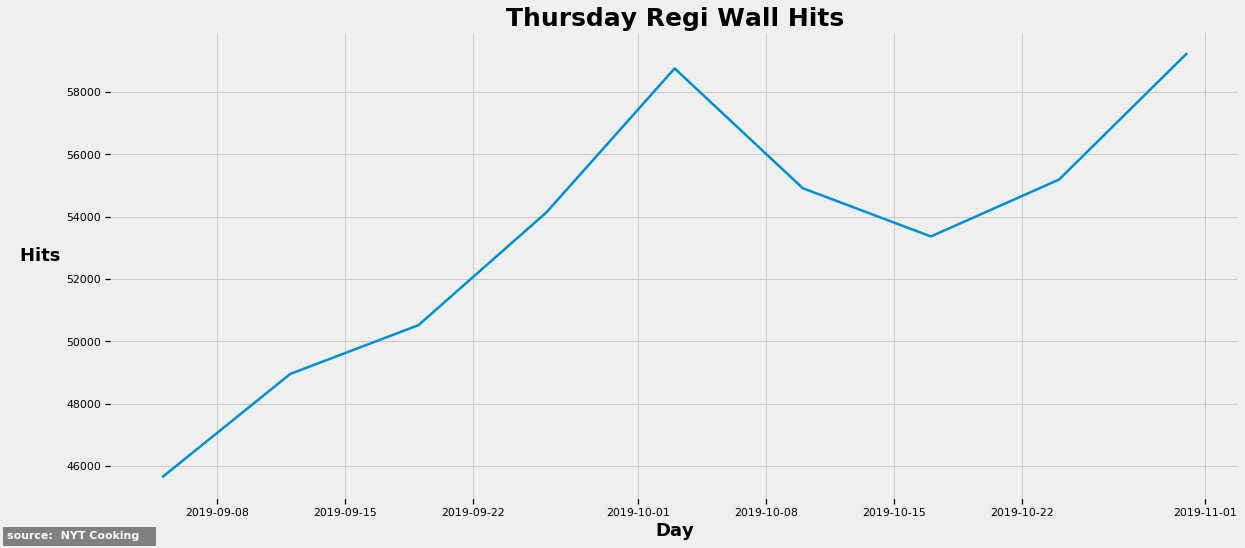

In [23]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfThurs)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Thursday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

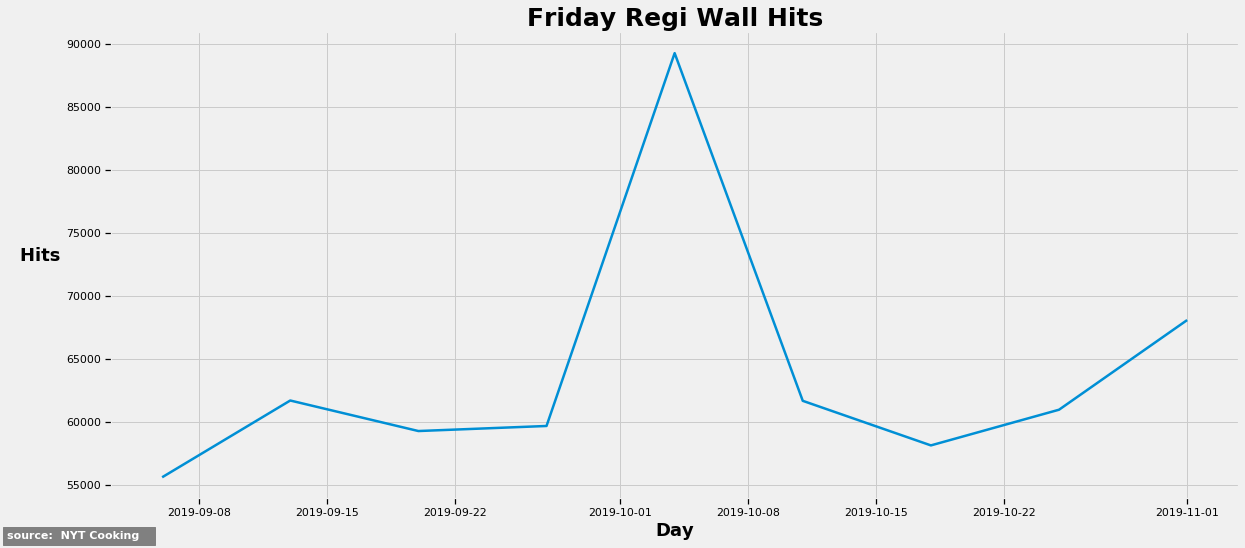

In [24]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfFri)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Friday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

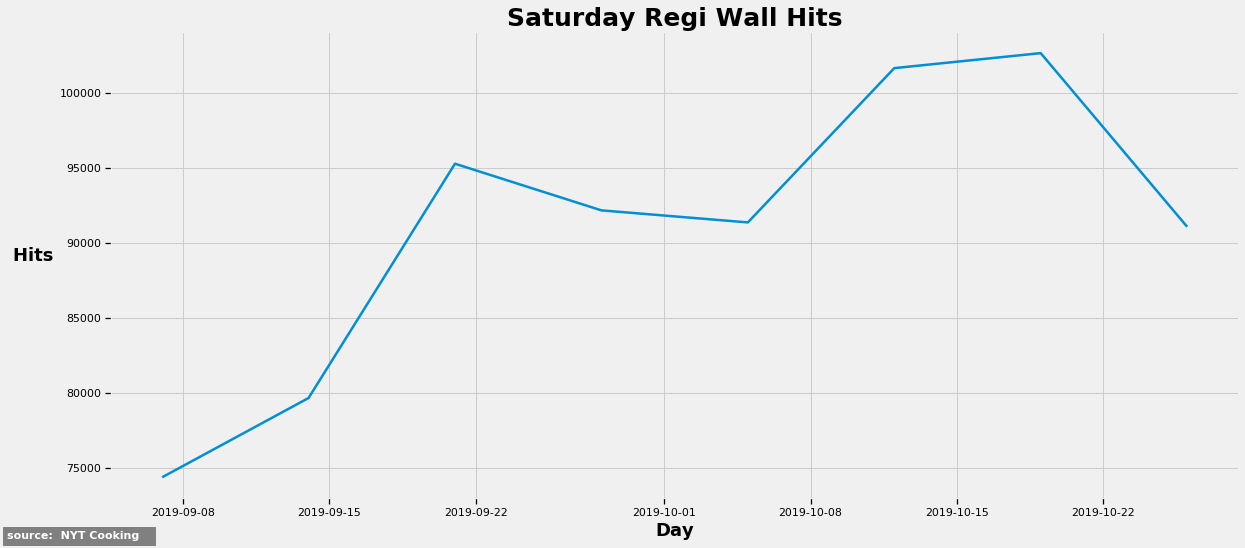

In [25]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfSat)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Saturday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

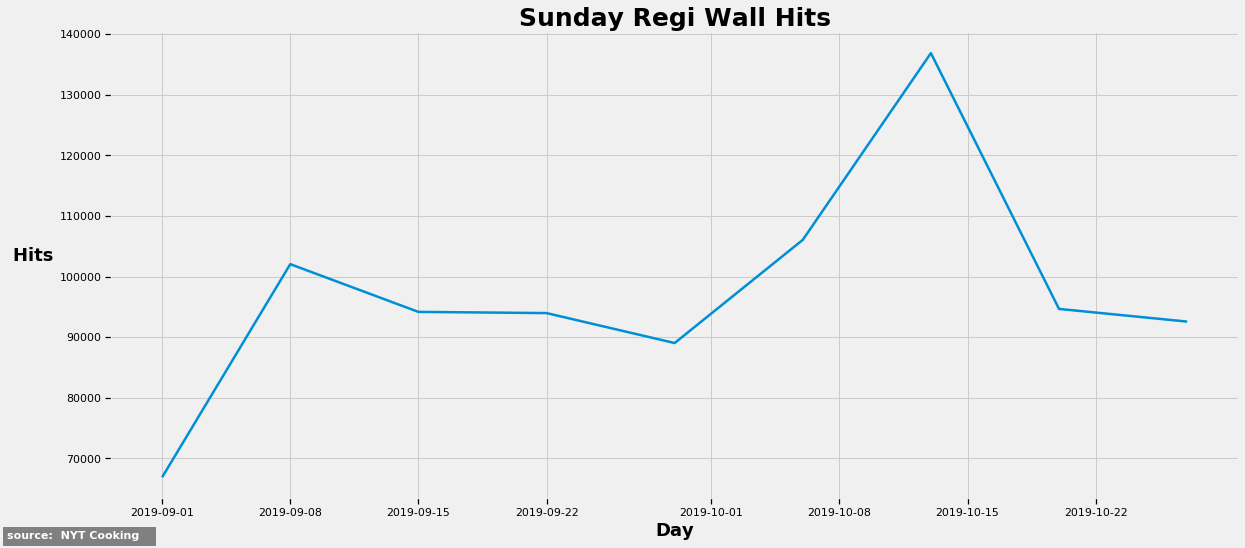

In [26]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 18,8

# remember: using dfnew 
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# Without HUE 
sb.lineplot(x="day", y="hitregiwall", data=dfSun)
#sb.lineplot(x="day", y="percenthitregiwall", data=dfnew)

#With Hue
#sb.lineplot(x="day", y="hitregiwall", hue="dayName", data=dfnew)  
#sb.lineplot(x="day", y="percenthitregiwall", hue="dayName", data=dfnew)

plt.title('Sunday Regi Wall Hits',fontsize=25,weight='bold')
plt.ylabel('Hits       ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

# Thresholds Below


In [40]:
# Monday Hit
  MondayAverage = np.mean(dfMon["hitregiwall"])
  MondaySD= np.std(dfMon["hitregiwall"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  minMon = dfMon["hitregiwall"].min() 

print('Threshold Monday Hit Regi: ', round(Mondaylow,2), '-' , round(MondayHigh,2), '| Minimum is: ', minMon)

# Monday %  
  MondayAverage1 = np.mean(dfMon["percenthitregiwall"])
  MondaySD1 = np.std(dfMon["percenthitregiwall"])
  Mondaylow1, MondayHigh1 = ( MondayAverage1 - (2*(MondaySD1)) ) , ( MondayAverage1 + (2*(MondaySD1)))
  minMon1 = dfMon["percenthitregiwall"].min() 


print('Threshold Monday % Hit Wall: ', round(Mondaylow1,2), '-', round(MondayHigh1,2), '| Minimum is: ', round(minMon1,2))

Threshold Monday Hit Regi:  52840.17 - 100459.16 | Minimum is:  63583
Threshold Monday % Hit Wall:  25.74 - 38.21 | Minimum is:  28.29


In [42]:
# Tuesday Hit
  TuesdayAverage = np.mean(dfTue["hitregiwall"])
  TuesdaySD= np.std(dfTue["hitregiwall"])
  Tuesdaylow, TuesdayHigh = (TuesdayAverage - (2*(TuesdaySD))) , (TuesdayAverage + (2*(TuesdaySD)))
  minTue = dfTue["hitregiwall"].min() 

print('Threshold Tuesday Hit Regi: ', round(Tuesdaylow,2), '-' , round(TuesdayHigh,2), '| Minimum is: ', minTue)

# Tuesday %  
  TuesdayAverage1 = np.mean(dfTue["percenthitregiwall"])
  TuesdaySD1 = np.std(dfTue["percenthitregiwall"])
  Tuesdaylow1, TuesdayHigh1 = ( TuesdayAverage1 - (2*(TuesdaySD1)) ) , ( TuesdayAverage1 + (2*(TuesdaySD1)))
  minTue1 = dfTue["percenthitregiwall"].min() 

print('Threshold Tueday % Hit Wall: ', round(Tuesdaylow1,2), '-', round(TuesdayHigh1,2), '| Minimum is: ', round(minTue1,2))

Threshold Monday Hit Regi:  42481.7 - 94620.74 | Minimum is:  57872
Threshold Monday % Hit Wall:  24.87 - 39.83 | Minimum is:  29.04


In [43]:
# Wednesday Hit
  WednesdayAverage = np.mean(dfWed["hitregiwall"])
  WednesdaySD= np.std(dfWed["hitregiwall"])
  Wednesdaylow, WednesdayHigh = ( WednesdayAverage - (2*(WednesdaySD)) ) , ( WednesdayAverage + (2*(WednesdaySD)))
  minWed = dfWed["hitregiwall"].min() 

print('Threshold Wednesday Hit Regi: ', round(Wednesdaylow,2), '-' , round(WednesdayHigh,2), '| Minimum is: ', minWed)

# Wednesday %  
  WednesdayAverage1 = np.mean(dfWed["percenthitregiwall"])
  WednesdaySD1 = np.std(dfWed["percenthitregiwall"])
  Wednesdaylow1, WednesdayHigh1 = ( WednesdayAverage1 - (2*(WednesdaySD1)) ) , ( WednesdayAverage1 + (2*(WednesdaySD1)))
  minWed1 = dfWed["percenthitregiwall"].min() 

print('Threshold Wednesday % Hit Wall: ', round(Wednesdaylow1,2), '-', round(WednesdayHigh1,2), '| Minimum is: ', round(minWed1,2))

Threshold Wednesday Hit Regi:  47376.08 - 78466.81 | Minimum is:  54823
Threshold Wednesday % Hit Wall:  28.08 - 34.56 | Minimum is:  29.75


In [44]:
# Thursday Hit
  ThursdayAverage = np.mean(dfThurs["hitregiwall"])
  ThursdaySD= np.std(dfThurs["hitregiwall"])
  Thursdaylow, ThursdayHigh = ( ThursdayAverage - (2*(ThursdaySD)) ) , ( ThursdayAverage + (2*(ThursdaySD)))
  minThurs = dfThurs["hitregiwall"].min() 

print('Threshold Thursday Hit Regi: ', round(Thursdaylow,2), '-' , round(ThursdayHigh,2), '| Minimum is: ', minThurs)

# Thursday %  
  ThursdayAverage1 = np.mean(dfThurs["percenthitregiwall"])
  ThursdaySD1 = np.std(dfThurs["percenthitregiwall"])
  Thursdaylow1, ThursdayHigh1 = ( ThursdayAverage1 - (2*(ThursdaySD1)) ) , ( ThursdayAverage1 + (2*(ThursdaySD1)))
  minThurs1 = dfThurs["percenthitregiwall"].min() 

print('Threshold Thursday % Hit Wall: ', round(Thursdaylow1,2), '-', round(ThursdayHigh1,2), '| Minimum is: ', round(minThurs1,2))

Threshold Thursday Hit Regi:  45058.62 - 61767.6 | Minimum is:  45643
Threshold Thursday % Hit Wall:  27.31 - 32.52 | Minimum is:  28.52


In [45]:
# Friday Hit
  FridayAverage = np.mean(dfFri["hitregiwall"])
  FridaySD= np.std(dfFri["hitregiwall"])
  Fridaylow, FridayHigh = ( FridayAverage - (2*(FridaySD)) ) , ( FridayAverage + (2*(FridaySD)))
  minFri = dfFri["hitregiwall"].min() 

print('Threshold Friday Hit Regi: ', round(Fridaylow,2), '-' , round(FridayHigh,2), '| Minimum is: ', minFri)

# Friday %  
  FridayAverage1 = np.mean(dfFri["percenthitregiwall"])
  FridaySD1 = np.std(dfFri["percenthitregiwall"])
  Fridaylow1, FridayHigh1 = ( FridayAverage1 - (2*(FridaySD1)) ) , ( FridayAverage1 + (2*(FridaySD1)))
  minFri1 = dfFri["percenthitregiwall"].min() 

print('Threshold Friday % Hit Wall: ', round(Fridaylow1,2), '-', round(FridayHigh1,2), '| Minimum is: ', round(minFri1,2))

Threshold Friday Hit Regi:  44753.38 - 82897.51 | Minimum is:  55622
Threshold Friday % Hit Wall:  27.47 - 37.92 | Minimum is:  30.67


In [46]:
# Saturday Hit
  SaturdayAverage = np.mean(dfSat["hitregiwall"])
  SaturdaySD= np.std(dfSat["hitregiwall"])
  Saturdaylow, SaturdayHigh = ( SaturdayAverage - (2*(SaturdaySD)) ) , ( SaturdayAverage + (2*(SaturdaySD)))
  minSat = dfSat["hitregiwall"].min() 

print('Threshold Saturday Hit Regi: ', round(Saturdaylow,2), '-' , round(SaturdayHigh,2), '| Minimum is: ', minSat)

# Saturday %  
  SaturdayAverage1 = np.mean(dfSat["percenthitregiwall"])
  SaturdaySD1 = np.std(dfSat["percenthitregiwall"])
  Saturdaylow1, SaturdayHigh1 = ( SaturdayAverage1 - (2*(SaturdaySD1)) ) , ( SaturdayAverage1 + (2*(SaturdaySD1)))
  minSat1 = dfSat["percenthitregiwall"].min() 

print('Threshold Saturday % Hit Wall: ', round(Saturdaylow1,2), '-', round(SaturdayHigh1,2), '| Minimum is: ', round(minSat1,2))

Threshold Saturday Hit Regi:  72685.09 - 109408.91 | Minimum is:  74390
Threshold Saturday % Hit Wall:  30.72 - 38.71 | Minimum is:  30.87


In [47]:
# Sunday Hit
  SundayAverage = np.mean(dfSun["hitregiwall"])
  SundaySD= np.std(dfSun["hitregiwall"])
  Sundaylow, SundayHigh = ( SundayAverage - (2*(SundaySD)) ) , ( SundayAverage + (2*(SundaySD)))
  minSun = dfSun["hitregiwall"].min() 

print('Threshold Sunday Hit Regi: ', round(Sundaylow,2), '-' , round(SundayHigh,2), '| Minimum is: ', minSun)

# Sunday %  
  SundayAverage1 = np.mean(dfSun["percenthitregiwall"])
  SundaySD1 = np.std(dfSun["percenthitregiwall"])
  Sundaylow1, SundayHigh1 = (SundayAverage1 - (2*(SundaySD1)) ) , ( SundayAverage1 + (2*(SundaySD1)))
  minSun1 = dfSun["percenthitregiwall"].min() 


print('Threshold Sunday % Hit Wall: ', round(Sundaylow1,2), '-', round(SundayHigh1,2), '| Minimum is: ', round(minSun1,2))

Threshold Sunday Hit Regi:  62689.33 - 132041.78 | Minimum is:  66903
Threshold Sunday % Hit Wall:  27.05 - 39.1 | Minimum is:  29.55


In [56]:
#np.mean(dfSun["hitregiwall"]) ##- (2*(np.std(dfSun["percenthitregiwall"])))

97365.55555555556